In [2]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from gdt.core.data_primitives import TimeEnergyBins
from gdt.missions.fermi.gbm.headers import PhaiiHeaders
from gdt.missions.fermi.gbm.phaii import Ctime

# function to convert the ASCII files from Peter to PHAII objects
def ascii_to_phaii(file):
    tstart = []
    tstop = []
    counts = []
    with open(file, 'r') as f:
        txt = list(f)
        for line in txt:
            t0, t1, c = line.split()
            tstart.append(float(t0))
            tstop.append(float(t1))
            counts.append(float(c.strip()))
    tstart = np.array(tstart)
    tstop = np.array(tstop)
    counts = np.array(counts)
    
    
    counts = np.tile(counts, (2,1)).T
     
    bins = TimeEnergyBins(counts, tstart, tstop, (tstop-tstart), 
                          np.array([5.0, 50.0]), np.array([50.0, 300.0]))
    phaii = Ctime.from_data(bins, detector='n0')
    return phaii

def shift_lightcurve(phaii, dt=0.):
    """Shift a lightcurve in time
    """
    counts = phaii.data.counts
    tstart = phaii.data.tstart + dt
    tstop = phaii.data.tstop + dt

    bins = TimeEnergyBins(counts, tstart, tstop, (tstop-tstart), 
                phaii.data.emin, phaii.data.emax)
    return Ctime.from_data(bins, headers=PhaiiHeaders(), detector='n9')

In [3]:
from gdt.missions.fermi.gbm.tte import GbmTte
from gdt.core.binning.unbinned import bin_by_time
from gdt.core.binning.binned import rebin_by_time, combine_by_factor

original = True

if original is not True:
    tte_n9 = GbmTte.open('data/glg_tte_n9_bn170206453_v00.fit')
    tte_na = GbmTte.open('data/glg_tte_na_bn170206453_v00.fit')
    tte_nb = GbmTte.open('data/glg_tte_nb_bn170206453_v00.fit')
    # bin the data
    phaii1 = tte_n9.to_phaii(bin_by_time, 0.064, time_ref=0.)
    phaii2 = tte_na.to_phaii(bin_by_time, 0.256, time_ref=0.)
    phaii3 = tte_nb.to_phaii(bin_by_time, 0.064, time_ref=0.)
    # cut tte files
    phaii1 = phaii1.slice_time((-11, 11))
    phaii2 = phaii2.slice_time((-11, 11))
    phaii3 = phaii3.slice_time((-11, 11))
    # shift lightcurves
    phaii2 = shift_lightcurve(phaii2, dt=0.3)
    phaii3 = shift_lightcurve(phaii3, dt=-0.2)
    # rebin lightcurves
    #phaii2 = phaii2.rebin_time(combine_by_factor, 4)

else:
    # load the three lightcurves
    phaii1 = ascii_to_phaii('data/LC_cat_v06_Npls6_catnum7_binned.txt')
    phaii2 = ascii_to_phaii('data/LC_cat_v06_Npls6_catnum8_binned.txt')
    phaii3 = ascii_to_phaii('data/LC_cat_v06_Npls6_catnum9_binned.txt')

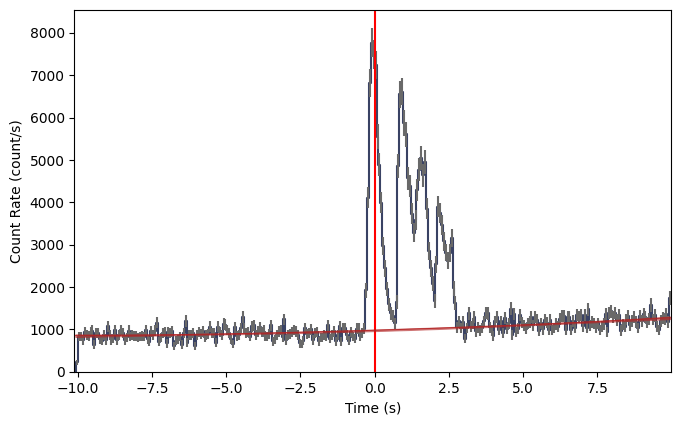

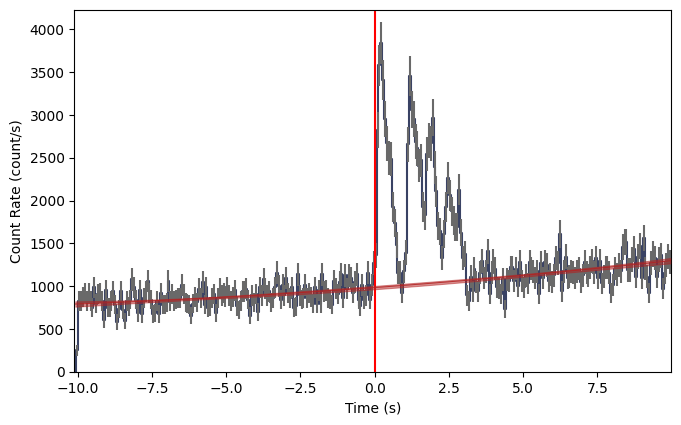

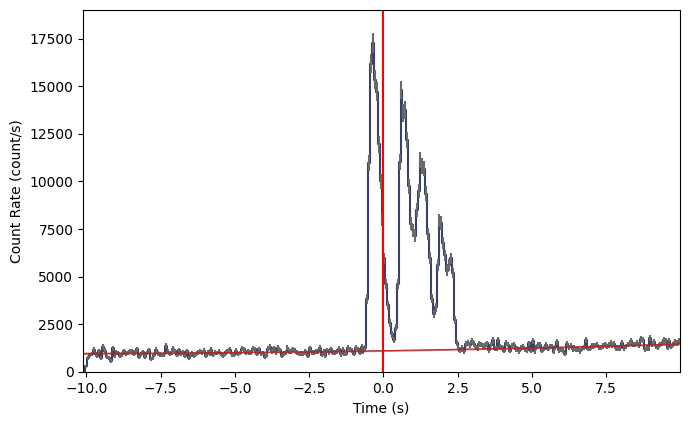

In [4]:
import matplotlib.pyplot as plt
from gdt.core.background.fitter import BackgroundFitter
from gdt.core.background.binned import Polynomial
from gdt.core.plot.lightcurve import Lightcurve

# define background intervals
background_intervals = [(-9.0, -2.0), (5.0, 9.0)]
energy_range = (50.0, 300.0)

# fit the background of the first lightcurve
bkgd_fitter = BackgroundFitter.from_phaii(phaii1, Polynomial, background_intervals)
bkgd_fitter.fit(order=2)
bkgd_model1 = bkgd_fitter.interpolate_bins(phaii1.data.tstart, phaii1.data.tstop)

# fit the background of the second lightcurve
bkgd_fitter = BackgroundFitter.from_phaii(phaii2, Polynomial, background_intervals)
bkgd_fitter.fit(order=2)
bkgd_model2 = bkgd_fitter.interpolate_bins(phaii2.data.tstart, phaii2.data.tstop)

# fit the background of the third lightcurve
bkgd_fitter = BackgroundFitter.from_phaii(phaii3, Polynomial, background_intervals)
bkgd_fitter.fit(order=2)
bkgd_model3 = bkgd_fitter.interpolate_bins(phaii3.data.tstart, phaii3.data.tstop)

# plot the three lightcurves
lcplot1 = Lightcurve(data=phaii1.to_lightcurve(energy_range=energy_range), 
                     background=bkgd_model1.integrate_energy(*energy_range))
lcplot2 = Lightcurve(data=phaii2.to_lightcurve(energy_range=energy_range), 
                     background=bkgd_model2.integrate_energy(*energy_range))
lcplot3 = Lightcurve(data=phaii3.to_lightcurve(energy_range=energy_range), 
                     background=bkgd_model3.integrate_energy(*energy_range))
lcplot1.ax.axvline(x=0, color='red')
lcplot2.ax.axvline(x=0, color='red')
lcplot3.ax.axvline(x=0, color='red')

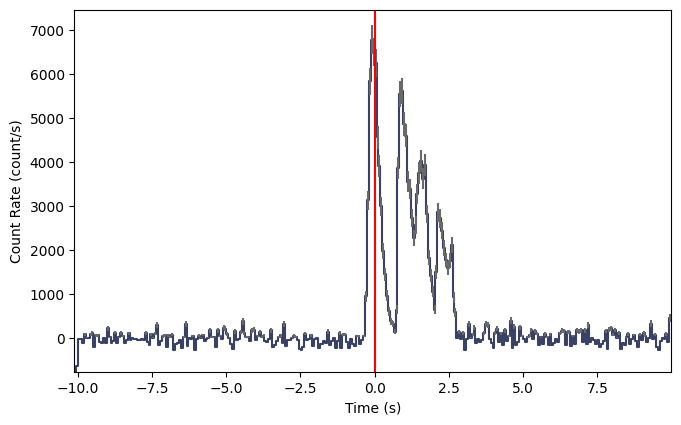

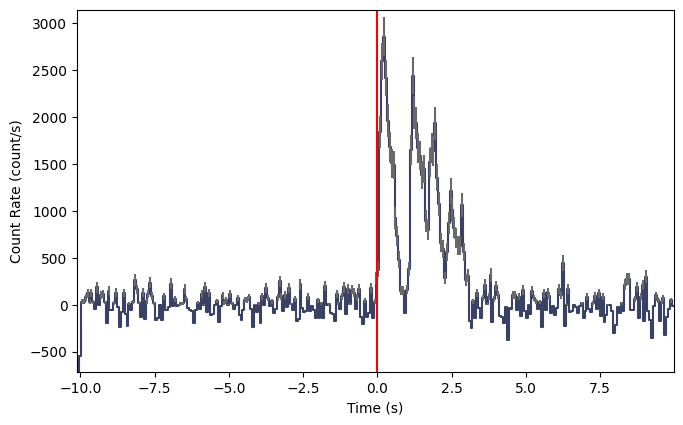

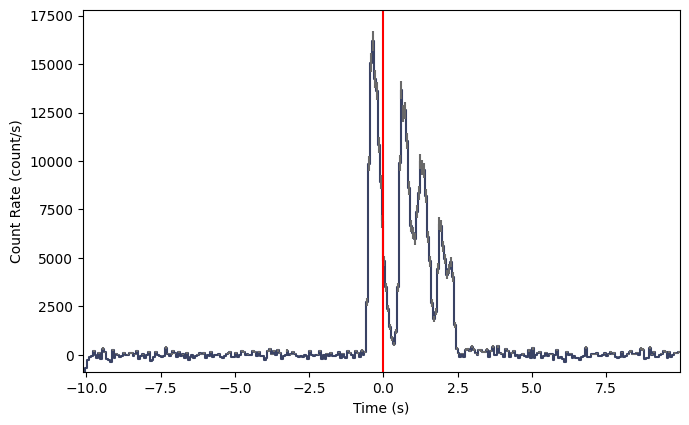

In [5]:
from gdt.ipn.instrument import Observation

# store the lightcurves and background as observations
observation1 = Observation(phaii1.to_lightcurve(energy_range=energy_range), 
                          background=bkgd_model1.integrate_energy(*energy_range))
observation2 = Observation(phaii2.to_lightcurve(energy_range=energy_range), 
                          background=bkgd_model2.integrate_energy(*energy_range))
observation3 = Observation(phaii3.to_lightcurve(energy_range=energy_range), 
                          background=bkgd_model3.integrate_energy(*energy_range))

# can make a plot of the background-subtracted lightcurves
lcplot1 = Lightcurve(data=observation1.background_subtract())
lcplot2 = Lightcurve(data=observation2.background_subtract())
lcplot3 = Lightcurve(data=observation3.background_subtract())
lcplot1.ax.axvline(x=0, color='red')
lcplot2.ax.axvline(x=0, color='red')
lcplot3.ax.axvline(x=0, color='red')

In [6]:
from gdt.ipn.instrument import Spacecraft, SpacecraftPosition

# Set spacecraft positions.  This example sets one spacecraft in LEO and another near the Moon.  
# Both are situated at RA=180, Dec=0
scpos1 = SpacecraftPosition.from_distance(500.0, 0.0)
scpos2 = SpacecraftPosition.from_distance(2e5, 0.0)
# this sets the spacecraft vector in geocentric coordinates (km)
scpos3 = SpacecraftPosition.from_vectors([350.0, -200.0, 350.0], [0.0, 0.0, 0.0])

# create spacecraft objects that contain both the spacecraft position and observation
spacecraft1 = Spacecraft(scpos1)
spacecraft1.set_observation(observation1)
spacecraft2 = Spacecraft(scpos2)
spacecraft2.set_observation(observation2)
spacecraft3 = Spacecraft(scpos3)
spacecraft3.set_observation(observation3)

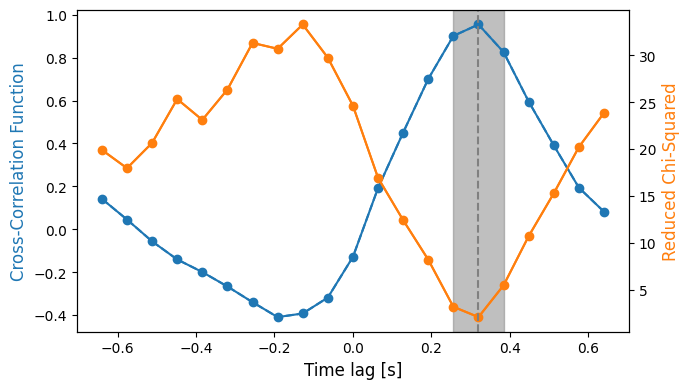

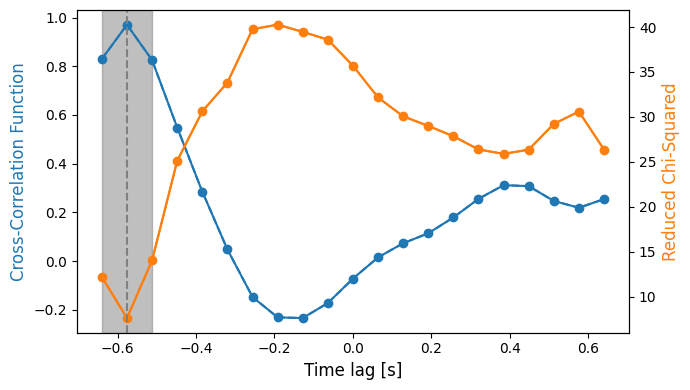

Time offset: 0.320 (+0.064, -0.064)
Time offset: -0.576 (+0.064, -0.064)


In [ ]:
from gdt.ipn.algorithms.ccf import Ipn, ClassicIpn

classic = False    

if classic is not True:
    # initialize old IPN localization with our spacecraft
    ipn1 = Ipn.from_list([spacecraft1, spacecraft2])
    ipn2 = Ipn.from_list([spacecraft2, spacecraft3])
else:
    # initialize old IPN localization with our spacecraft
    ipn1 = ClassicIpn.from_list([spacecraft1, spacecraft2])
    ipn2 = ClassicIpn.from_list([spacecraft2, spacecraft3])

# perform the localization(s)
# input the source regions for lightcurve1 and lightcurve2 (must be approx the same duration)
ipn1.localize((0.,3), (0.,3))
ipn2.localize((0.,3.), (0.,3.))

# plot the fit of the CCF and chisq between the observations
ipn1.plot_fit()
ipn2.plot_fit()

# the time offset and error
# Lightcurve 1 relative to Lightcurve 2
print('Time offset: {0:.3f} (+{1:.3f}, -{2:.3f})'.format(ipn1.time_offset.dt, ipn1.time_offset.err[1], ipn1.time_offset.err[0]))
print('Time offset: {0:.3f} (+{1:.3f}, -{2:.3f})'.format(ipn2.time_offset.dt, ipn2.time_offset.err[1], ipn2.time_offset.err[0]))

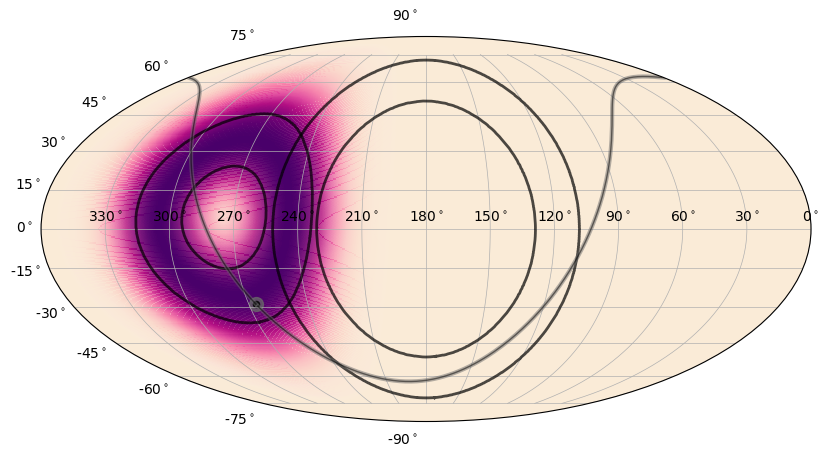

In [8]:
from gdt.core.plot.sky import EquatorialPlot
from gdt.core.healpix import HealPixLocalization

# generate the healpix objects
# this may take a little time because the healpix nside is dependent on the width of the annulus:
# the smaller the annulus width, the higher the nside
hpx1 = ipn1.get_healpix(nside=256)
hpx2 = ipn2.get_healpix(nside=256)

# plot the maps on the sky
# First annulus from ipn1
skyplot = EquatorialPlot()
skyplot.add_localization(hpx1, clevels=[0.90], gradient=True, sun=False, earth=False, detectors=[])

# Add annulus from ipn2 
skyplot.add_localization(hpx2, clevels=[0.68], gradient=True, sun=False, earth=False, detectors=[])
plt.show()
plt.close()

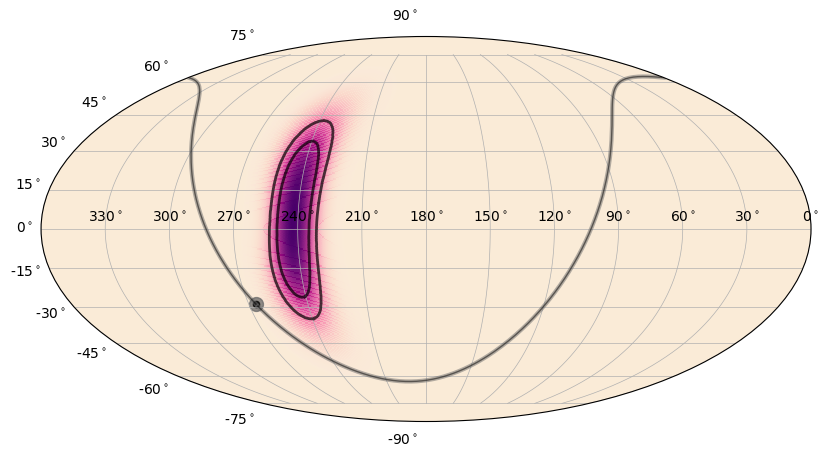

In [9]:
import healpy as hp

# Create the joint probability skymaps
nside = hpx1.nside  # Ensure both maps are the same resolution before multiplication
prob1 = hpx1.prob if hpx1.nside == nside else hp.ud_grade(hpx1.prob, nside_out=nside)
prob2 = hpx2.prob if hpx2.nside == nside else hp.ud_grade(hpx2.prob, nside_out=nside)

joint_prob = prob1 * prob2
joint_prob /= joint_prob.sum()  # normalize

# Make a new HealPixLocalization object
joint_hpx = HealPixLocalization.from_data(joint_prob)

#skypatch plot 
skyplot = EquatorialPlot()
skyplot.add_localization(joint_hpx, clevels=[0.68, 0.90], sun=False, earth=False, detectors=[])
plt.show()
plt.close()